In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
IGNORE_IDS = [38]
results_dir = Path("./results/TAG-Benchmark")

In [3]:
all_latencies = []
sample_level_latencies = []
for f in (results_dir / "blendsql").iterdir():
    if f.name.startswith("predictions"):
        curr_df = pd.read_csv(f)
        curr_df = curr_df[~curr_df["Query ID"].isin(IGNORE_IDS)]
        all_latencies.append(curr_df["latency"].mean())
        sample_level_latencies.append(curr_df["latency"].tolist())
all_latencies = np.array(all_latencies)
print(all_latencies.mean())
print(all_latencies.std())
avg_sample_level_blendsql = np.array(sample_level_latencies).mean(axis=0)
query_ids = curr_df['Query ID'].tolist()

0.7719262486797268
0.006445250345590585


In [4]:
all_latencies = []
sample_level_latencies = []
for f in (results_dir / "lotus").iterdir():
    if f.name.startswith("lotus_outputs"):
        curr_results = json.load(open(f))
        curr_results = [i for i in curr_results if int(i['query_id']) not in IGNORE_IDS]
        id_to_result = {int(item['query_id']): item for item in curr_results}
        all_latencies.append(np.mean([i['latency'] for i in curr_results]))
        sample_level_latencies.append([id_to_result[query_id]['latency'] for query_id in query_ids])
all_latencies = np.array(all_latencies)
print(all_latencies.mean())
print(all_latencies.std())
avg_sample_level_lotus = np.array(sample_level_latencies).mean(axis=0)

1.6672515618599069
0.0623962648890169


In [5]:
df = pd.DataFrame(
    {
        "blendsql": avg_sample_level_blendsql,
        "lotus": avg_sample_level_lotus,
        "query_id": query_ids
    }
)
df = pd.melt(df, id_vars=["query_id"], var_name="Program", value_name="Latency (s)")

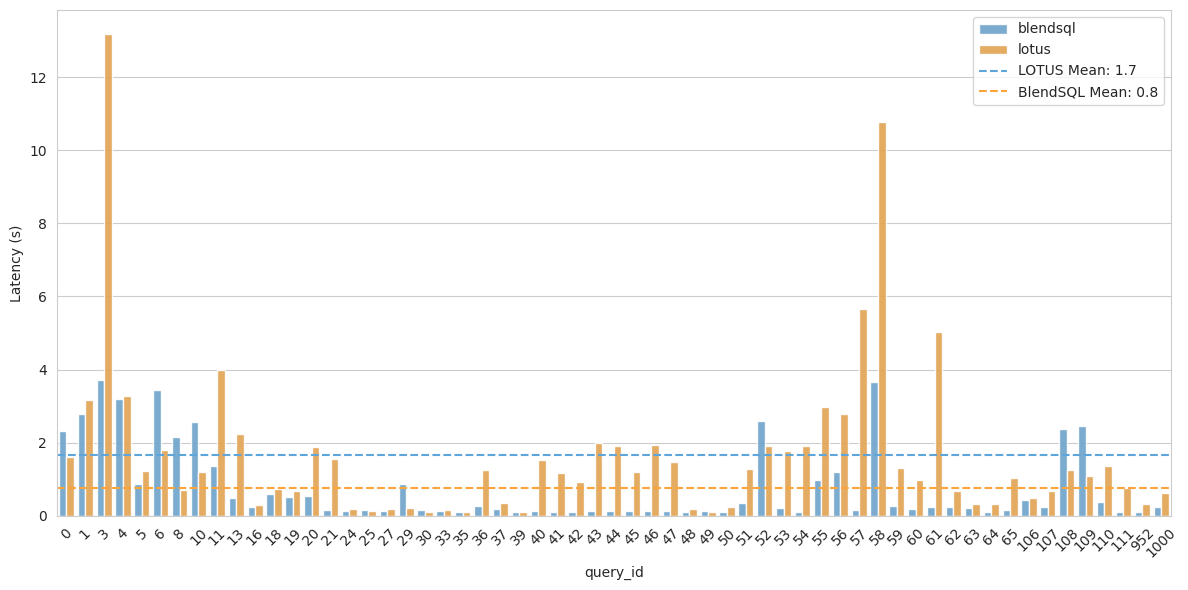

In [8]:
# Set aesthetic parameters
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Create the main bar plot
ax = sns.barplot(
    x="query_id",
    y="Latency (s)",
    hue="Program",
    data=df,
    palette=["#5DA5DA", "#FAA43A"],
    alpha=0.9,
)

lotus_mean = avg_sample_level_lotus.mean()
plt.axhline(
    y=lotus_mean, color="#5DA5DA", linestyle="--", label=f"LOTUS Mean: {avg_sample_level_lotus.mean():.1f}"
)

blendsql_mean = avg_sample_level_blendsql.mean()
plt.axhline(
    y=blendsql_mean, color="#FAA43A", linestyle="--", label=f"BlendSQL Mean: {blendsql_mean:.1f}"
)
# Improve legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles, labels=labels, title="", loc="upper right", frameon=True
)

# Add value labels on top of each bar
# for container in ax.containers:
#     ax.bar_label(container, fmt='%.0f', padding=3)
plt.xticks(rotation=45)
# Adjust layout
plt.tight_layout()
plt.savefig("latency_stats.pdf")